<a href="https://colab.research.google.com/github/kithmini-wijesiri/sample_projects/blob/master/Unsupervised_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# basic imports
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
datapath = './'

# import autograd wrapped numpy
import autograd.numpy as np

##**Learning a linear Autoencoder using graident descent**

We use gradient descent optimizer to tune the parameters of the autoencoder for an  𝑁=2  dimensional dataset, which has already been centered. Here we will seek out only a single learned basis vector, and examine its final encoded and decoded versions visually.

In [ ]:
# using an automatic differentiator - like the one imported via the statement below - makes coding up gradient descent a breeze
from autograd import numpy as np
from autograd import value_and_grad

# gradient descent function - inputs: g (input function), alpha (steplength parameter), max_its (maximum number of iterations), w (initialization)
def gradient_descent(g,alpha_choice,max_its,w,version):
    # compute the gradient function of our input function - note this is a function too
    # that - when evaluated - returns both the gradient and function evaluations (remember
    # as discussed in Chapter 3 we always ge the function evaluation 'for free' when we use
    # an Automatic Differntiator to evaluate the gradient)
    gradient = value_and_grad(g)

    # run the gradient descent loop
    weight_history = []      # container for weight history
    cost_history = []        # container for corresponding cost function history
    alpha = 0
    for k in range(1,max_its+1):
        # check if diminishing steplength rule used
        if alpha_choice == 'diminishing':
            alpha = 1/float(k)
        else:
            alpha = alpha_choice

        # evaluate the gradient, store current weights and cost function value
        cost_eval,grad_eval = gradient(w)
        weight_history.append(w)
        cost_history.append(cost_eval)

        if version == 'full':
            grad_norm = np.linalg.norm(grad_eval)
            if grad_norm == 0:
                grad_norm += 10**-6*np.sign(2*np.random.rand(1) - 1)
            grad_eval /= grad_norm

        # normalize components
        if version == 'component':
            component_norm = np.abs(grad_eval) + 10**(-8)
            grad_eval /= component_norm

        if version == 'none':
            grad_eval = grad_eval

        # take gradient descent step
        w = w - alpha*grad_eval

    # collect final weights
    weight_history.append(w)
    # compute final cost function value via g itself (since we aren't computing
    # the gradient at the final step we don't get the final cost function value
    # via the Automatic Differentiatoor)
    cost_history.append(g(w))
    return weight_history,cost_history

In [ ]:
# a quick mockup of the autoencoder model
def model(x,C):
    # perform encoding
    W = np.dot(C.T,x)

    # perform decoding
    a = np.dot(C,W)
    return a

# an implementation of the least squares cost function for linear regression
# implement the following function
def autoencoder(C):
    cost = np.sum((model(x,C) - x)**2)
    return cost/float(x.shape[1])


In [ ]:
# load in a dataset to learn a PCA basis for via the autoencoder
x = np.loadtxt(datapath + '2d_span_data_centered.csv',delimiter=',')

np.random.seed(5819)
# tune the autoencoder via gradient descent
g = autoencoder; alpha_choice = 10**(-4); max_its = 1000;
C = np.array([[-3.5],[3.5]])
weight_history,cost_history = gradient_descent(g, alpha_choice, max_its, C, version='none')

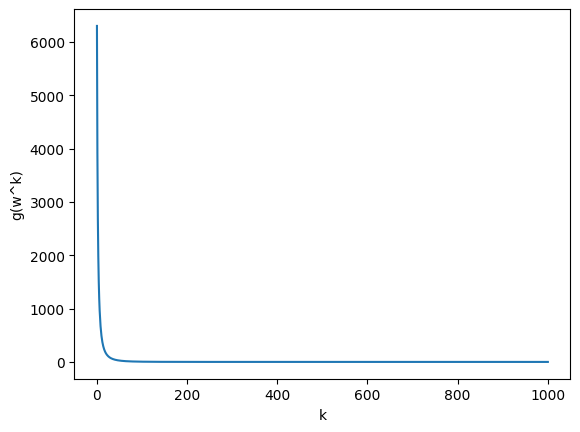

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(cost_history);
plt.xlabel("k");
plt.ylabel("g(w^k)");

In [ ]:
C = weight_history[-1]

In [ ]:
x

array([[-0.28315208, -3.77878804, -2.79670032, -2.0522026 , -0.01135876,
         1.11008937,  4.61954675,  1.82592169, -4.27349851,  4.28372191,
        -2.92582822,  0.55226104, -3.24493005,  0.39832527, -1.5364192 ,
         0.43511603,  0.91357227, -0.86588074, -5.42114262,  1.58265053,
         2.39580353,  0.78933341, -0.75158159, -0.6684528 , -0.9267404 ,
         1.1719944 , -1.4283769 ,  0.43538447,  1.3760795 ,  4.04917493,
         1.1572051 ,  1.02692258,  0.77809727, -2.06372334, -2.77774455,
         1.61415221, -2.40664554,  3.7050371 ,  1.44531635,  2.55633061,
         0.27799088, -0.07301707,  0.8763912 ,  2.58451996,  0.80250973,
        -0.93500654,  3.68458677, -4.05133395, -0.13610099, -3.03941005],
       [-0.63136352,  5.56177409,  2.13923135,  3.69703689,  1.28279872,
         1.6754717 , -6.6794353 , -1.85067917,  3.95455894, -4.43135317,
         2.89229966, -0.38186398,  2.62840034,  0.46989844,  1.25187134,
        -0.39102789,  0.16180167, -0.51911264,  6.

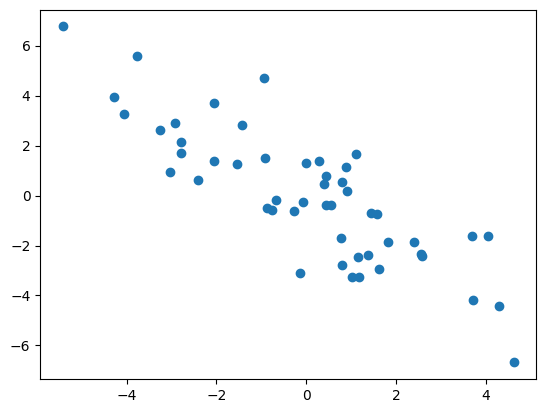

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
# Plot the scatter plot
plt.scatter(x[0], x[1])
plt.show()

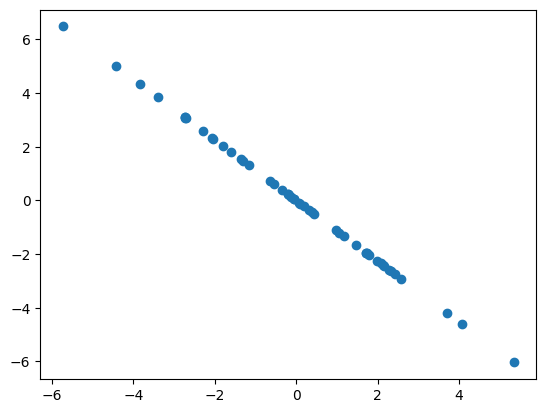

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
# Plot the scatter plot
x1 = model(x,C)
plt.scatter(x1[0], x1[1])
plt.show()

##**Producing a PCA basis**

In [ ]:
# implement the following function
def center(X):
    '''
    A function for normalizing each feaure dimension of an input array, mean-centering
    and division by its standard deviation

    '''
    X_means = np.mean(X,axis=1)[:,np.newaxis]
    X_normalized = X - X_means

    return X_normalized

# implement the following function
def compute_pcs(X,lam):
    '''
    A function for computing the principal components of an input data matrix.  Both
    principal components and variance parameters (eigenvectors and eigenvalues of XX^T)
    are returned
    '''
    # create the correlation matrix
    P = float(X.shape[1])
    Cov = 1/P*np.dot(X,X.T) + lam*np.eye(X.shape[0])

    # use numpy function to compute eigenvalues / vectors of correlation matrix
    D,V = np.linalg.eigh(Cov)

    return D,V

def pca_transform_data(X,**kwargs):
    '''
    A function for producing the full PCA transformation on an input dataset X.
    '''
    # user-determined number of principal components to keep, and regularizer penalty param
    num_components = X.shape[0]
    if 'num_components' in kwargs:
        num_components = kwargs['num_components']
    lam = 10**(-7)
    if 'lam' in kwargs:
        lam = kwargs['lam']

    # compute principal components
    D,V = compute_pcs(X,lam)
    V = V[:,-num_components:]
    D = D[-num_components:]

    # compute transformed data for PC space: V^T X
    W = np.dot(V.T,X)
    return W,V

In [ ]:
# load in dataset to perform PCA on, and mean-center
X_original = np.loadtxt(datapath + '2d_span_data.csv',delimiter=',')

# mean-center the data
X = center(X_original)

# compute the full PCA transformation of dataset
W,V = pca_transform_data(X)

In [ ]:
W

array([[ 0.62413791, -0.71146955,  0.75131154, -0.82365708, -0.82046788,
        -1.92998386,  0.79233381, -0.19707167,  0.70483666, -0.40446228,
         0.36309697, -0.1745813 ,  0.77715611, -0.60765721,  0.3632076 ,
        -0.07927162, -0.80167456,  0.99623133, -0.23414997, -0.72975976,
        -0.61392303, -0.95393801,  0.94439822,  0.63084535, -0.27070721,
         1.20581086, -0.74084884, -0.84433767,  0.49383769, -2.04797806,
         0.69834702,  1.33311009,  0.49775188,  0.68215737,  1.00781778,
         0.66993721,  1.44321825, -0.12646139, -0.64903317, -0.44084681,
        -1.09302281,  0.23439927, -1.40137744, -0.40644612,  1.19448047,
        -2.31540458, -1.75983297,  0.97331605,  2.09588434,  1.70074108],
       [-0.29874213,  6.68628306,  3.43996721,  4.1474337 ,  0.9861714 ,
         0.56095111, -8.08252901, -2.59232833,  5.77966532, -6.15008736,
         4.09805182, -0.6483315 ,  4.10293648,  0.10109542,  1.94829311,
        -0.57960744, -0.4670246 ,  0.16355586,  8.

In [ ]:
V

array([[-0.7630423 , -0.64634856],
       [-0.64634856,  0.7630423 ]])

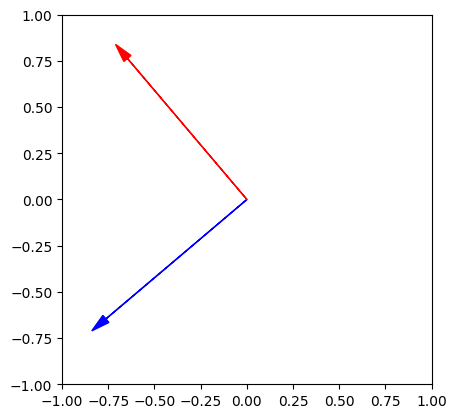

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Set up the plot
fig, ax = plt.subplots()
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)

# Plot the basis vectors
ax.arrow(0, 0, V[0,0], V[1,0], head_width=0.05, head_length=0.1, fc='b', ec='b')
ax.arrow(0, 0, V[0,1], V[1,1], head_width=0.05, head_length=0.1, fc='r', ec='r')

# Set the aspect ratio to 'equal'
ax.set_aspect('equal')

# Show the plot
plt.show()

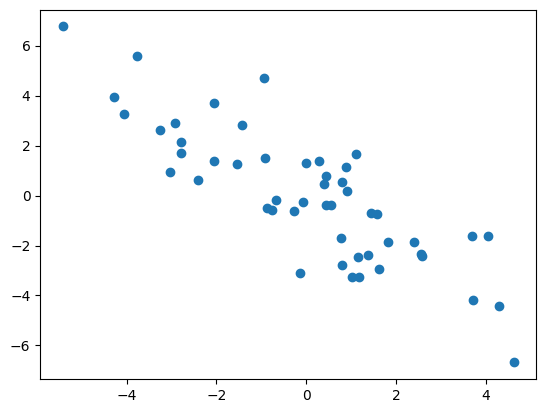

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
# Plot the scatter plot

plt.scatter(X[0], X[1])
plt.show()

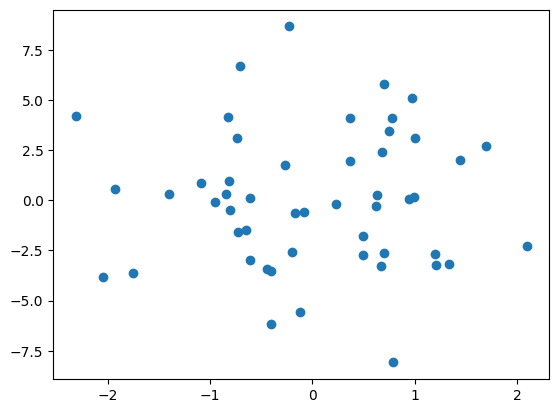

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
# Plot the scatter plot

plt.scatter(W[0], W[1])

plt.show()

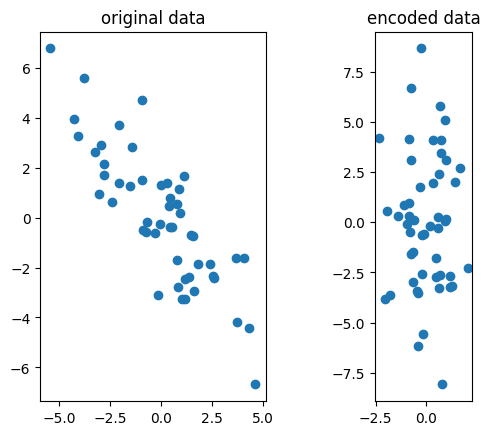

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2)

# Plot X in the first subplot
ax1.scatter(X[0], X[1])
ax1.set_title('original data')

# Plot W in the second subplot
ax2.scatter(W[0], W[1])
ax2.set_title('encoded data')
ax2.set_aspect('equal')

# Show the plot
plt.show()

##**Perform K-Means**

In [ ]:
####### K-means functionality #######
# function for updating cluster assignments
def update_assignments(data,centroids):
    P = np.shape(data)[1]
    assignments = []
    for p in range(P):
        # get pth point
        x_p = data[:,p][:,np.newaxis]

        # compute distance between pth point and all centroids
        # using numpy broadcasting
        diffs = np.sum((x_p - centroids)**2,axis = 0)

        # determine closest centroid
        ind = np.argmin(diffs)
        assignments.append(ind)
    return np.array(assignments)

# update centroid locations
def update_centroids(data,old_centroids,assignments):
    K = old_centroids.shape[1]
    # new centroid container
    centroids = []
    for k in range(K):
        # collect indices of points belonging to kth cluster
        S_k = np.argwhere(assignments == k)

        # take average of points belonging to this cluster
        c_k = 0
        if np.size(S_k) > 0:
            c_k = np.mean(data[:,S_k],axis = 1)
        else:  # what if no points in the cluster?  keep previous centroid
            c_k = copy.deepcopy(old_centroids[:,k])[:,np.newaxis]
        centroids.append(c_k)
    centroids = np.array(centroids)[:,:,0]
    return centroids.T

# main k-means function
def my_kmeans(data,centroids,max_its):
    # outer loop - alternate between updating assignments / centroids
    for j in range(max_its):
        # update cluter assignments
        assignments = update_assignments(data,centroids)

        # update centroid locations
        centroids = update_centroids(data,centroids,assignments)

    # final assignment update
    assignments = update_assignments(data,centroids)
    return centroids,assignments

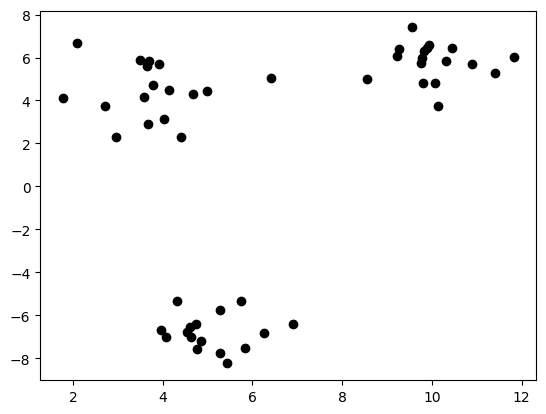

In [ ]:
from sklearn.datasets import make_blobs

np.random.seed(5819)
P = 50 # Number of data points
# Generate P samples with 3 centers
blobs, labels = make_blobs(n_samples=P, centers=3)
data = np.transpose(blobs)

# scatter plot the dataset
plt.scatter(data[0,:],data[1,:],c = 'k')
plt.show()

In [ ]:
# initial centroids - here particular chosen
pt_inds = [20,21,22]
init_centroids = data[:,pt_inds]
max_its = 1000

centroids,assignments = my_kmeans(data,init_centroids,max_its)

In [ ]:
centroids

array([[ 3.7641701 , 10.04216392,  5.08013767],
       [ 4.43204136,  5.79809726, -6.78039231]])

In [ ]:
centroids = centroids.T

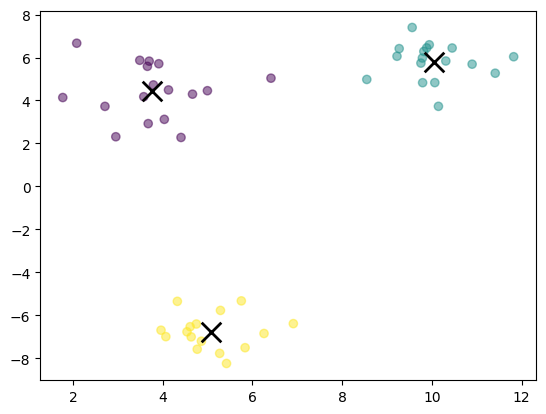

In [ ]:
import matplotlib.pyplot as plt

# Plot the blobs and the centroids
fig, ax = plt.subplots()
ax.scatter(blobs[:, 0], blobs[:, 1], c=labels, cmap='viridis', alpha=0.5)
ax.scatter(centroids[:,0], centroids[:, 1], marker='x', s=200, linewidths=2, color='black')

# Show the plot
plt.show()